In [24]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import requests
from scipy import stats
import pickle
import ast
import seaborn as sns

In [25]:
DATASET_TO_NAME = {
    "reddit": "Reddit",
    "news": "Patch news",
    "papers": "ArXiv",
}

DATASET_TO_DATASET_NAME = {
    "reddit": "Reddit",
    "news": "Patch news",
    "papers": "ArXiv",
}


REWRITTEN_TYPE_TO_SHORT = {
    "syntax_grammar": "SG",
    "rephrase": "R",
}

LLM_TO_NAME = {
    "original": "Original",
    "gpt": "GPT3.5",
    "llama": "Llama 3",
    "gemini": "Gemini",
}

In [26]:
def get_embeddings(list_of_ids, list_of_texts, results_embeddings={}):
    for _id, essay in tqdm(zip(list_of_ids, list_of_texts), total=len(list_of_ids)):
        if str(_id) in results_embeddings.keys():
            continue
        api_key = os.environ.get("OPENAI_API_KEY")
        url = "https://api.openai.com/v1/embeddings"
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        }
        data = {
            "input": essay,
            "model": "text-embedding-ada-002",
            "encoding_format": "float",
        }

        # Send the POST request
        response = requests.post(url, headers=headers, json=data)

        # Check the response status and content
        if response.status_code == 200:
            # Successful request, you can access the response data using response.json()
            response_data = response.json()
            results_embeddings[str(_id)] = response_data
        else:
            # Request failed, print the error message
            print(
                f"Request failed with status code {response.status_code}: {response.text}"
            )
            continue
    return results_embeddings

## Check the semantic similarity of the original essays and the rewritten essays

In [ ]:
def load_data():
    all_data = None
    for llm in ["gpt", "gemini", "llama"]:
        for dataset_name in ["papers", "reddit", "news"]:
            for rewrite_type in ["syntax_grammar", "rephrase"]:  # ,
                log_file_name = f"{dataset_name}_rewritten_{rewrite_type}_{llm}.json"
                with open(os.path.join(dataset_name, log_file_name)) as f:
                    data = pd.read_json(f, orient="index")
                    data["index"] = data.index
                    data["dataset"] = dataset_name
                    data["rewrite_type"] = rewrite_type
                    data["llm"] = llm
                    data.reset_index(drop=True, inplace=True)
                    if all_data is None:
                        all_data = data
                    else:
                        all_data = pd.concat([all_data, data], ignore_index=True)
    return all_data


all_data = load_data()

In [28]:
all_data

,original_text,rewritten_text,index,dataset,rewrite_type,llm
0,Hyperspectral remote sensing is a prominent ...,Hyperspectral remote sensing is a prominent re...,1812.10788,papers,syntax_grammar,gpt
1,"In this paper, we introduce a novel framewor...",This paper presents a new framework for addres...,2305.04628,papers,syntax_grammar,gpt
2,"Monocular 3D object detection, with the aim ...",Monocular 3D object detection is a promising r...,2011.14589,papers,syntax_grammar,gpt
3,"Recently, vision transformer based multimoda...","Recently, there have been advancements in visi...",2307.13958,papers,syntax_grammar,gpt
4,We present a method for estimating detailed ...,We introduce a novel method for accurately est...,1803.0634,papers,syntax_grammar,gpt
...,...,...,...,...,...,...
7188,A Roxbury Township woman was arrested and char...,\boxed{\nA 26-year-old woman from Roxbury Town...,259330,news,rephrase,llama
7189,Decorating Event Time is drawing,$\boxed{\text{The time for decorating the even...,459154,news,rephrase,llama
7190,Bethel Historical Society Ghost Tour. Conta...,\boxed{Don't miss out on the Bethel Historical...,796172,news,rephrase,llama
7191,"Gama Sonic USA, Inc., a leading manufacturer o...","\boxed{\nGama Sonic USA, Inc., a prominent man...",184791,news,rephrase,llama


In [29]:
random_index = (
    all_data[(all_data["llm"] == "gpt") & (all_data["dataset"] == "reddit")]["index"]
    .sample(1)
    .values[0]
)
print("Original Story:")
print(
    all_data[
        (all_data["llm"] == "gpt")
        & (all_data["dataset"] == "reddit")
        & (all_data["rewrite_type"] == "rephrase")
        & (all_data["index"] == random_index)
    ]["original_text"].values[0]
)
print("Rephrased Story:")
print(
    all_data[
        (all_data["llm"] == "gpt")
        & (all_data["dataset"] == "reddit")
        & (all_data["rewrite_type"] == "rephrase")
        & (all_data["index"] == random_index)
    ]["rewritten_text"].values[0]
)
print("---------------------------------")
print("Syntax Grammar Story:")
print(
    all_data[
        (all_data["llm"] == "gpt")
        & (all_data["dataset"] == "reddit")
        & (all_data["rewrite_type"] == "syntax_grammar")
        & (all_data["index"] == random_index)
    ]["rewritten_text"].values[0]
)

Original Story:
I said to be nice not creepy. “Sorry, sorry,” Oliver mumbled to himself. “She just had a really nice smile, you know? I mean, after Jenny left me I never thought I’d meet another person who was just right for me. But then she walked in and -” What is her name? “Uh, well, that’s the thing. I didn’t actually manage to catch it. But really, what’s in a name?” You cannot tell a woman you love her if you do not know her name. “I’ll try and avoid being nice, then,” Oliver quipped. He felt the demon’s frustration, but it didn’t say anything. “Well, what do you want me to do?” Just be normal for once. Okay? Try talking to the girl at the bar. “Okay, okay,” Oliver smoothed his hair and sauntered over with his head up and shoulders squared like the demon had taught him. The blonde at the bar turned around, and her face fell when she saw him. “Oh god, no, no no,” Oliver turned on his heel and pushed through the crowd to the exit. Where are you going? I told you already that you ha

In [30]:
if os.path.exists("new_embeddings_for_all_datasets_for_study2.pkl"):
    all_embeddings = pickle.load(
        open("new_embeddings_for_all_datasets_for_study2.pkl", "rb")
    )
else:
    all_embeddings = {}

In [ ]:
dataset_name_list = []
llm_list = []
rewrite_type_list = []
similarities = []
indices = []

for dataset_name in tqdm(all_data["dataset"].unique(), leave=False):
    for llm in tqdm(all_data["llm"].unique(), leave=False):
        for rewrite_type in tqdm(all_data["rewrite_type"].unique(), leave=False):
            sub_data = all_data[
                (all_data["llm"] == llm)
                & (all_data["dataset"] == dataset_name)
                & (all_data["rewrite_type"] == rewrite_type)
            ]
            for index in sub_data["index"].values:
                try:
                    original_embedding = all_embeddings[
                        f"{dataset_name}_original_{index}"
                    ]["data"][0]["embedding"]
                    rewritten_embedding = all_embeddings[
                        f"{dataset_name}_{rewrite_type}_{llm}_{index}"
                    ]["data"][0]["embedding"]
                    similarity = cosine_similarity(
                        np.array([original_embedding]), np.array([rewritten_embedding])
                    )[0][0]
                    similarities.append(similarity)
                    indices.append(index)
                    dataset_name_list.append(dataset_name)
                    llm_list.append(llm)
                    rewrite_type_list.append(rewrite_type)
                except:
                    continue


similarities_df = pd.DataFrame(
    {
        "dataset": dataset_name_list,
        "llm": llm_list,
        "rewrite_type": rewrite_type_list,
        "similarity": similarities,
        "index": indices,
    }
)

In [32]:
similarities_df["dataset"].unique()

array(['papers', 'reddit', 'news'], dtype=object)

In [33]:
similarities_df.to_csv("similarities_df.csv", index=False)

In [34]:
print(
    "Ratio of all the similarities that are above 0.95: ",
    len(similarities_df[similarities_df["similarity"] > 0.94]) / len(similarities_df),
)

Ratio of all the similarities that are above 0.95:  0.7601445247359644


In [35]:
# per dataset, do a t-test on the similarity column between the two conditions of prompt being SG and R, but also paired using the id column
from scipy.stats import mannwhitneyu

for dataset in similarities_df["dataset"].unique():
    dataset_df = similarities_df[similarities_df["dataset"] == dataset]
    sg_similarities = (
        dataset_df[dataset_df["rewrite_type"] == "syntax_grammar"]
        .groupby("index")["similarity"]
        .mean()
    )
    r_similarities = (
        dataset_df[dataset_df["rewrite_type"] == "rephrase"]
        .groupby("index")["similarity"]
        .mean()
    )

    common_ids = sg_similarities.index.intersection(r_similarities.index)
    sg_similarities = sg_similarities.loc[common_ids]
    r_similarities = r_similarities.loc[common_ids]

    # sort based on the ids
    sg_similarities.sort_index(inplace=True)
    r_similarities.sort_index(inplace=True)

    t_stat, p_value = mannwhitneyu(
        sg_similarities.values, r_similarities.values, alternative="greater"
    )
    print(f"Dataset: {dataset}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")

    print("-------------------")

Dataset: papers
t-statistic: 17495.0
p-value: 0.9848871260408827
-------------------
Dataset: reddit
t-statistic: 36775.0
p-value: 5.311509134743168e-48
-------------------
Dataset: news
t-statistic: 22669.0
p-value: 0.010487294285362669
-------------------


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_38870/3701136059.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(


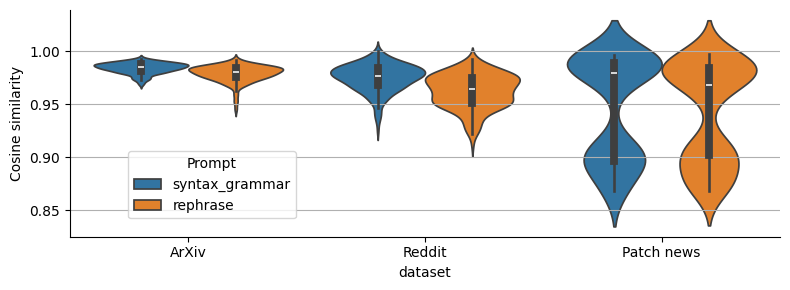

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax, model_in_use in zip([axs], ["gpt"]):

    bplot = sns.violinplot(
        similarities_df[(similarities_df["llm"] == model_in_use)],
        density_norm="width",
        x="dataset",
        y="similarity",
        hue="rewrite_type",
        ax=ax,
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()
axs.legend(
    handles,
    labels,
    title="Prompt",
    loc="lower center",
    bbox_to_anchor=(0.20, 0.05),
    ncol=1,
    alignment="center",
)
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"similarities_different_prompts.png", dpi=900, bbox_inches="tight")
plt.show()

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_38870/946105926.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(


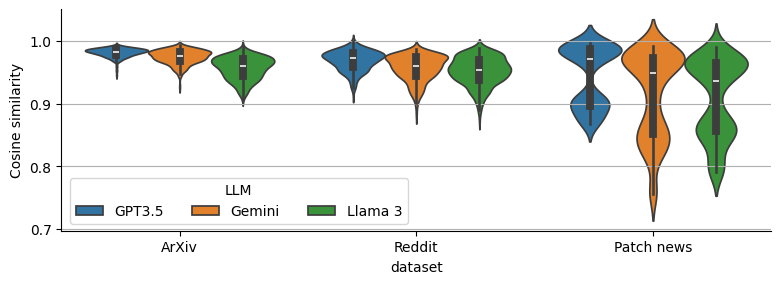

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax in [axs]:

    bplot = sns.violinplot(
        similarities_df,
        density_norm="width",
        x="dataset",
        y="similarity",
        hue="llm",
        ax=ax,
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()

axs.legend(
    handles,
    [LLM_TO_NAME[label] for label in labels],
    title="LLM",
    loc="lower center",
    bbox_to_anchor=(0.25, 0.00),
    ncol=3,
    alignment="center",
)
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"similarities_different_llms.png", dpi=900, bbox_inches="tight")
plt.show()

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_38870/3849223523.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(


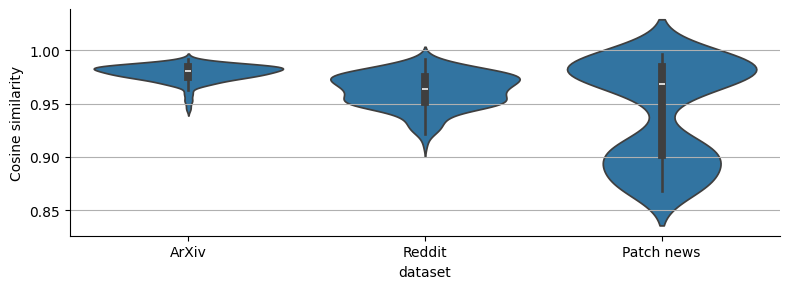

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax, model_in_use in zip([axs], ["gpt"]):

    bplot = sns.violinplot(
        similarities_df[
            (similarities_df["llm"] == model_in_use)
            & (similarities_df["rewrite_type"] == "rephrase")
        ],
        density_norm="width",
        x="dataset",
        y="similarity",
        ax=ax,
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()
# axs.legend(
#     handles,
#     [
#         {val: key for key, val in REWRITTEN_TYPE_TO_SHORT.items()}[label]
#         for label in labels
#     ],
#     title="Prompt",
#     loc="lower center",
#     bbox_to_anchor=(0.75, 0.05),
#     ncol=2,
#     alignment="center",
# )
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"similarities_only_gpt.png", dpi=900, bbox_inches="tight")
plt.show()